#### Task 1

In [3]:
import numpy as np
import torch

Generating the dataset

In [50]:
np.random.seed(45)
num_samples = 40
   
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [53]:
# Reshape and convert to tensors
x = torch.from_numpy(x1.reshape(-1, 1))
y = torch.from_numpy(y.reshape(-1, 1))

In [55]:
theta0 = torch.zeros(1,requires_grad=True)
theta1 = torch.zeros(1,requires_grad=True)

In [56]:
def lossfn(theta0, theta1, x, y):
    y_pred = theta0 + theta1*x
    return torch.mean((y_pred - y)**2)

In [58]:
loss = lossfn(theta0, theta1, x, y)
loss.backward()
print(theta0.grad.item())
print(theta1.grad.item())

-7.447053909301758
-1.0253016948699951


In [60]:
grads = []
theta0 = torch.zeros(1,requires_grad=True)
theta1 = torch.zeros(1,requires_grad=True)
for i in range(num_samples):
    loss = lossfn(theta0, theta1, x, y)
    loss.backward()
    grads.append([theta0.grad.item(), theta1.grad.item()])
    theta0.grad.zero_()
    theta1.grad.zero_()
    

In [61]:
grad0 = [g[0] for g in grads]
grad1 = [g[1] for g in grads]
print(np.mean(grad0))
print(np.mean(grad1))

-7.447053909301758
-1.0253016948699951


In [244]:
def gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 100, min_loss = 0.00):
    epsilon = 0.001
    # Initialize the weights
    theta0 = torch.zeros(1,requires_grad=True)
    theta1 = torch.zeros(1,requires_grad=True)
    trajectory = []
    for i in range(epochs):
        for j in range(num_samples//batch_size):
            lower = j*batch_size
            upper = min((j+1)*batch_size, num_samples)
            X_batch, y_batch = x[lower:upper], y[lower:upper]
            loss = lossfn(theta0, theta1, X_batch, y_batch)
            loss.backward()
            # Update the weights (stop tracking the gradients)
            with torch.no_grad():
                theta0 -= lr * theta0.grad
                theta1 -= lr * theta1.grad
            # Zero the gradients    
            theta0.grad.zero_()
            theta1.grad.zero_()
        current_loss = lossfn(theta0, theta1, x, y).item()
        trajectory.append({'epoch':i+1, 
                        'theta0': theta0.item(),
                        'theta1': theta1.item(),
                        'loss': current_loss
                    })
        if current_loss <= min_loss + epsilon:
                break
    return trajectory
                
        
        

 Find optimal loss via normal eqn

In [62]:
X = torch.cat([torch.ones_like(x), x], dim=1)
theta_optimal = torch.inverse(X.t() @ X) @ X.t() @ y
y_pred_optimal = X @ theta_optimal
min_loss = torch.mean((y - y_pred_optimal) ** 2).item()

print(f"Optimal parameters: θ0 = {theta_optimal[0].item():.4f}, θ1 = {theta_optimal[1].item():.4f}")
print(f"Minimum loss: {min_loss:.6f}")


Optimal parameters: θ0 = 3.9507, θ1 = 2.6825
Minimum loss: 0.595754


In [245]:
gd = gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 700, min_loss = min_loss)
sgd = gradient_descent(lr = 0.01, batch_size = 1, epochs = 700, min_loss = min_loss)
bgd = gradient_descent(lr = 0.01, batch_size = num_samples//4, epochs = 700, min_loss = min_loss)

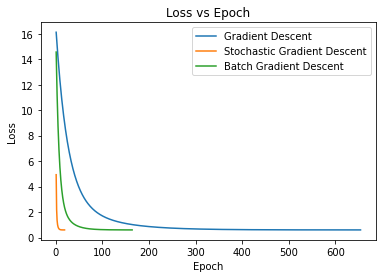

In [246]:
import matplotlib.pyplot as plt

# Extract the loss values for each method
gd_loss = [item['loss'] for item in gd]
sgd_loss = [item['loss'] for item in sgd]
bgd_loss = [item['loss'] for item in bgd]

# Plot the loss versus epoch
plt.plot(range(1,gd[-1]['epoch']+1), gd_loss, label='Gradient Descent')
plt.plot(range(1,sgd[-1]['epoch']+1), sgd_loss, label='Stochastic Gradient Descent')
plt.plot(range(1,bgd[-1]['epoch']+1), bgd_loss, label='Batch Gradient Descent')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Add legend
plt.legend()

# Show the plot
plt.show()

 $\epsilon$ neighbourhood of optimal loss is [$loss_{opt}$, $loss_{opt}$ + $\epsilon$] = [0.5957, 0.5967]

In [247]:
print("Full Batch Gradient Descent")
print(gd[-1])
print("Stochastic Gradient Descent")
print(sgd[-1])
print("Batch Gradient Descent")
print(bgd[-1])

Full Batch Gradient Descent
{'epoch': 654, 'theta0': 3.9437949657440186, 'theta1': 2.625840902328491, 'loss': 0.5967484549094932}
Stochastic Gradient Descent
{'epoch': 19, 'theta0': 3.9780147075653076, 'theta1': 2.6614882946014404, 'loss': 0.5967359758676546}
Batch Gradient Descent
{'epoch': 164, 'theta0': 3.9457709789276123, 'theta1': 2.625985860824585, 'loss': 0.5967389411848956}


Full batch gradient descent takes the most number of epochs (654) to converge sufficiently close as compared to stochastic gradient descent (19) and mini-batch gradient descent (164). This is because gradient descent takes a granular approach by calculating gradients on entire dataset and then applying updates to the weights every epoch. However BGD and SGD calculate gradients on a smaller subset (one example for SGD) and apply multiple weight updates every epoch helping them converge quicker.  

In [285]:
theta0_range = np.linspace(0, 8, 100)
theta1_range = np.linspace(0, 6, 100)
T0, T1 = np.meshgrid(theta0_range, theta1_range)
# Compute the loss surface
Z = np.zeros_like(T0)
for i in range(T0.shape[0]):
    for j in range(T0.shape[1]):
        Z[i,j] = lossfn(torch.tensor(T0[i,j]), torch.tensor(T1[i,j]), x, y).item()

In [292]:
from matplotlib.animation import FuncAnimation
methods = [('Full-batch GD', gd[:15], 'r'), ('Mini-batch GD', bgd[:15], 'g'), ('SGD', sgd[:15], 'b')]
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contour(T0, T1, Z, levels=20, cmap='viridis')
ax.clabel(contour, inline=True, fontsize=8)
ax.set_xlabel('θ0')
ax.set_ylabel('θ1')
lines = [ax.plot([], [], f'{color}o-', label=name, linewidth=1.5, markersize=5)[0] 
         for name, _, color in methods]
ax.legend()
title = ax.set_title('Gradient Descent Methods')
epoch_disp = ax.text(0.5, 0.95, '', transform=ax.transAxes, 
                     fontsize=16, horizontalalignment='center')
def animate(i):
    for line, (name, trajectory, _) in zip(lines, methods):
        theta0_values = [trajectory[epoch]['theta0'] for epoch in range(i+1)]
        theta1_values = [trajectory[epoch]['theta1'] for epoch in range(i+1)]
        line.set_data(theta0_values, theta1_values)
    epoch_disp.set_text(f'Epoch: {i+1}')
    return lines + [title]
anim = FuncAnimation(fig, animate, frames=15, interval=100, blit=True)
anim.save('gradient_descent.gif', writer='pillow', fps=3)
plt.close()
    

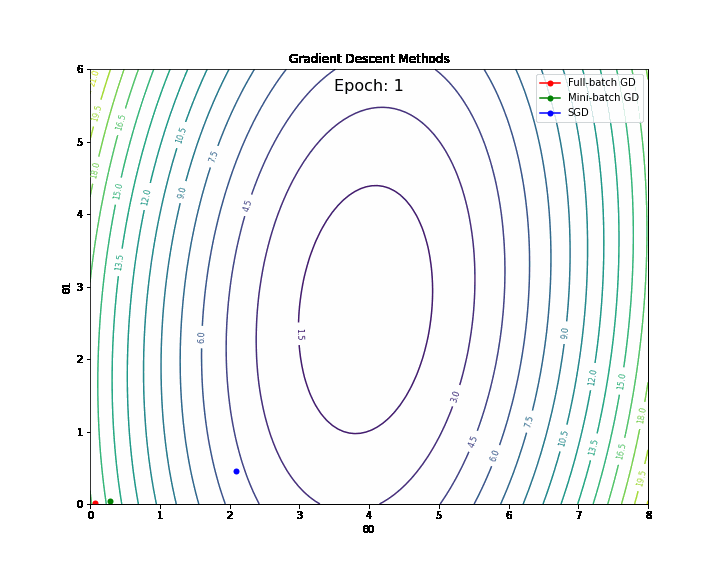

In [293]:
from IPython.display import Image
Image(filename='gradient_descent.gif')